In [3]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import pytz
from pandas.tseries.holiday import USFederalHolidayCalendar

try: import setGPU
except ImportError: pass
import warnings
import torch

import model_classes, nets
from constants import *

from model_classes import SolvePointQP

from data import get_data, get_decision_mask, get_decision_mask_

%load_ext autoreload
%autoreload 2

warnings.simplefilter("ignore")

DEVICE = "cpu"
if torch.cuda.is_available(): 
    DEVICE = "cuda"
print("DEVICE", DEVICE, "hi")

X_train, Y_train, X_test, Y_test, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt = get_data(DEVICE) 
variables = {'X_train_': X_train_pt, 'Y_train_': Y_train_pt, 
        'X_test_': X_test_pt, 'Y_test_': Y_test_pt}

params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}

mask = get_decision_mask(Y_train_pt, DEVICE)

EPOCHS_rmse = 200

print("TRAINING 2-STAGE")
model_rmse = model_classes.Net(X_train[:,:-1], Y_train, [200, 200]).to(DEVICE)
model_rmse = nets.run_rmse_net(model_rmse, variables, X_train, Y_train, EPOCHS_rmse)
model_rmse.eval()

EPOCHS_e2e = 200

DEVICE cuda hi
TRAINING 2-STAGE


In [4]:
print("TRAINING END-to-END")
end_to_end_net = nets.train_end_to_end(X_train[:,:-1], Y_train, variables, params, 400, DEVICE)
end_to_end_net.eval()

TRAINING END-to-END
epoch: 0   7.076281595230102
epoch: 40   0.5060939967632294
epoch: 80   0.5236818462610244
epoch: 120   0.4743406862020493
epoch: 160   0.4059876769781113
epoch: 200   0.454367795586586
epoch: 240   0.4150490939617157
epoch: 280   0.43022537529468535
epoch: 320   0.39918155074119566
epoch: 360   0.36887070834636687


Net(
  (lin): Linear(in_features=149, out_features=24, bias=True)
  (net): Sequential(
    (0): Linear(in_features=149, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=24, bias=True)
  )
)

In [43]:
print("TRAIN P-MODEL")
p_net = nets.train_pnet(end_to_end_net, X_train_pt, Y_train_pt, params, 4000, DEVICE)
p_net.eval();

TRAIN P-MODEL
epoch: 0   0.6573361301651368
epoch: 400   0.3190522448718548
epoch: 800   0.2999183376133442
epoch: 1200   0.27544659331440924
epoch: 1600   0.2560316100716591
epoch: 2000   0.21483309477567672
epoch: 2400   0.20836980134248734
epoch: 2800   0.162343715056777
epoch: 3200   0.16640380404889585
epoch: 3600   0.1537547094374895


In [49]:
print("TRAIN F-MODEL")
# f_net = model_classes.FNet(X_train[:,:-1], Y_train, [200, 200]).to(DEVICE)
f_net = nets.train_fnet(f_net, p_net, X_train[:,:-1], Y_train, variables, params, 2000, DEVICE)
f_net = nets.train_fnet(f_net, p_net, X_train[:,:-1], Y_train, variables, params, 1000, DEVICE)

end_to_end_net.eval()
f_net.eval()

TRAIN F-MODEL
epoch: 0   6.316125539668764
epoch: 20   2.021723942467943
epoch: 40   1.3697894487716258
epoch: 60   0.7491422634012997
epoch: 80   0.5837190938461572
epoch: 100   0.4810561820864677
epoch: 120   0.3526567765045911
epoch: 140   0.3228773647360504
epoch: 160   0.25604692070744933
epoch: 180   0.2006636093277484
epoch: 200   0.20967606752645224
epoch: 220   0.1639321044832468
epoch: 240   0.13132232539821417
epoch: 260   0.11149565057829022
epoch: 280   0.08247498942539096
epoch: 300   0.07197086235508322
epoch: 320   0.06981588509865105
epoch: 340   0.05129634535871446
epoch: 360   0.044604587403591724
epoch: 380   0.040130992438644174
epoch: 400   0.03476650718133897
epoch: 420   0.032404085197485985
epoch: 440   0.025339666465297343
epoch: 460   0.021650879108347
epoch: 480   0.02496978293871507
epoch: 500   0.023879343215376138
epoch: 520   0.021281579758506267
epoch: 540   0.01699419452343136
epoch: 560   0.01923705095425248
epoch: 580   0.017375068094115705
epoch: 60

KeyboardInterrupt: 

In [111]:
reward_learner = nets.train_reward_learner(p_net, X_train[:,:-1], Y_train, variables, params, 1000, DEVICE)

0 0.47279265537284887
10 0.16790841024369002
20 0.10892745139077306
30 0.0950512196496129
40 0.06959898885339498
50 0.0720302745513618
60 0.05633622452616691
70 0.0524920111708343
80 0.047747493470087644
90 0.04430131669156254
100 0.04877741193398833
110 0.03576730298809707
120 0.03166512189432979
130 0.031055872831493615
140 0.038662606375291945
150 0.028064408265054228
160 0.026045271828770637
170 0.025796851613558828
180 0.019808474723249675
190 0.022545581059530376
200 0.025326395877636968
210 0.017896042198408395
220 0.01936896703671664
230 0.020359293818473817
240 0.01500707883387804
250 0.014655404910445213
260 0.01592853389447555
270 0.015408592589665204
280 0.017856102485675363
290 0.01566837869118899
300 0.019335665665566923
310 0.01441868103807792
320 0.01053253426682204
330 0.015574186916928738
340 0.010673644233029335
350 0.015900321899680422
360 0.010673281348426827
370 0.013339139763265848
380 0.008072051194030792
390 0.011278042749036104
400 0.013017928538611159
410 0.0

In [112]:
all_rewards = []
for w in range(24):
    r = reward_learner(X_test_pt, w).cpu().detach()
    all_rewards.append(list(r))
reward_losses = []
# print(reward_actions.shape)
all_rewards = np.array(all_rewards)
reward_actions = np.argmin(all_rewards, axis=0)
print(all_rewards.shape)
print(reward_actions.shape)

(24, 639)
(639,)


In [22]:
def task_loss_no_mean(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
        params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0))

def pred_obj(x, w): 
    f_pred = f_net(x, w)
    m = get_decision_mask_(f_pred, DEVICE, w)

    p_pred = p_net(x, f_pred, m)

    v2 = p_pred[:,w:]
    v1 = p_net(x, torch.zeros_like(f_pred), torch.zeros_like(f_pred))[:,:w]
    # v1 = f_pred[:,:w]
    
    # print(e_pred)
    v = torch.cat((v1, v2), 1)

    loss = nets.task_loss(v, f_pred, params).mean()
    return loss.item()


def eval_decision(x, y, w):
    f_pred = f_net(x, w)
    m = get_decision_mask_(y, DEVICE, w)

    p_pred = p_net(x, y, m)
    
    v1 = p_net(x, y, torch.zeros_like(y))[:,:w]
    # v1 = f_pred[:,:w]
    v2 = p_pred[:,w:]
            
    v = torch.cat((v1, v2), 1)

    loss = nets.task_loss(v, y, params).mean()
    return loss.item()

In [113]:
vanilla = [] 
ours = [] 
random = []
optimal = []
two_stage = []
all_costs = []
end_to_end_net.eval()
f_net.eval()
p_net.eval()
reward_losses = []


for indx in range(len(X_test_pt)):
# for indx in [2]:
    X_t = X_test_pt[indx:indx+1,:]
    Y_t = Y_test_pt[indx:indx+1,:]
    # X_t = X_train_pt[indx:indx+1,:]
    # Y_t = Y_train_pt[indx:indx+1,:]

    # e2e = nets.task_loss(end_to_end_net.predict(X_t), Y_t, params).mean().item()
    e2e_pred = p_net(X_t, torch.zeros_like(Y_t), torch.zeros_like(Y_t))
    e2e = nets.task_loss(e2e_pred, Y_t, params).mean().item() 

    ts = nets.task_loss(model_rmse(X_t), Y_t, params).mean().item()
    
    print("end-to-end cost:", e2e)
    print("2-stage    cost:", ts)

    a = 0.0
    best_cost = 1e5 
    best_w = -1
    cur_costs = [] 
    for w in range(24):
        c = pred_obj(X_t, w)
        # print(w, c)
        if c < best_cost: 
            best_cost = c
            best_w = w
            
    our = eval_decision(X_t, Y_t, best_w) + a*best_w

    r = np.random.randint(24)
    rand = eval_decision(X_t, Y_t, r) + a*r
    
    print("TRUE")
    best_cost = 1e5 
    best_dec = -1
    uniform_random = 0
    for w in range(24): 
        cur = eval_decision(X_t, Y_t, w) + a*w
        # print(w, cur)
        if cur < best_cost: 
            best_cost = cur 
            best_dec = w
        uniform_random += cur
        cur_costs.append(cur)
    all_costs.append(cur_costs)
    
    reward_loss = eval_decision(X_t, Y_t, reward_actions[indx]) 
    reward_losses.append(reward_loss)
    
    # if best_dec == 0: continue 
    
    optimal.append(best_cost)
    vanilla.append(e2e)    
    ours.append(our)
    random.append(uniform_random/24)
    two_stage.append(ts)
    
    print("CHOSEN  true cost:", best_w, our)
    print("RANDOM  true cost: ", -1, uniform_random/24)
    print("OPTIMAL true cost:", best_dec, best_cost)
    print("REWARDL true cost:", reward_actions[indx], reward_loss)
    print()


end-to-end cost: 0.2785796523094177
2-stage    cost: 0.4729428291320801
TRUE
CHOSEN  true cost: 5 0.18271511793136597
RANDOM  true cost:  -1 0.2086476640154918
OPTIMAL true cost: 2 0.17348530888557434
REWARDL true cost: 9 0.1967487633228302

end-to-end cost: 0.24664771556854248
2-stage    cost: 0.24551591277122498
TRUE
CHOSEN  true cost: 5 0.18453297019004822
RANDOM  true cost:  -1 0.1976772683362166
OPTIMAL true cost: 2 0.17139339447021484
REWARDL true cost: 9 0.19339919090270996

end-to-end cost: 0.3124611973762512
2-stage    cost: 0.37757569551467896
TRUE
CHOSEN  true cost: 2 0.23353350162506104
RANDOM  true cost:  -1 0.2527272632966439
OPTIMAL true cost: 15 0.2217484563589096
REWARDL true cost: 9 0.25112831592559814

end-to-end cost: 0.28278452157974243
2-stage    cost: 0.3346765637397766
TRUE
CHOSEN  true cost: 3 0.16561508178710938
RANDOM  true cost:  -1 0.20395414407054582
OPTIMAL true cost: 2 0.16439536213874817
REWARDL true cost: 9 0.19092169404029846

end-to-end cost: 0.33322

In [114]:
# best sinle action
avg_cost_per_action = np.mean(all_costs, axis=0)
all_costs = np.array(all_costs)

single_action=1
# single_action = np.argmin(avg_cost_per_action)

In [115]:
print("VANILLA e2e", np.mean(vanilla), np.std(vanilla))
print("Our app    ", np.mean(ours), np.std(ours))
print("Reward    ", np.mean(reward_losses), np.std(reward_losses))
print("random     ", np.mean(random), np.std(random))
print("optimal    ", np.mean(optimal), np.std(optimal))
print("2-s        ", np.mean(two_stage), np.std(two_stage))
print("single ac  ", avg_cost_per_action[single_action], single_action)

VANILLA e2e 0.3416497173000576 0.15759335290045912
Our app     0.2344044741004099 0.18334679132974632
Reward     0.2458472025809527 0.2033228542176346
random      0.26286865825228967 0.1326009546746231
optimal     0.19231618123481717 0.060190846601738235
2-s         1.4667654952139293 1.949003708463955
single ac   0.23592908297999177 1


In [116]:
QUANTILE = 0.5
print("VANILLA e2e  ", np.quantile(vanilla, QUANTILE), np.std(vanilla))
print("Our app      ", np.quantile(ours, QUANTILE), np.std(ours))
print("random       ", np.quantile(random, QUANTILE), np.std(random))
print("reward       ", np.quantile(reward_losses, QUANTILE), np.std(random))
print("optimal      ", np.quantile(optimal, QUANTILE), np.std(optimal))
print("single ac    ", np.quantile(all_costs[:,single_action], QUANTILE))
print("2-stage      ", np.quantile(two_stage, QUANTILE), np.std(two_stage))

VANILLA e2e   0.33921799063682556 0.15759335290045912
Our app       0.20388516783714294 0.18334679132974632
random        0.2492748306443294 0.1326009546746231
reward        0.2193143367767334 0.1326009546746231
optimal       0.1873791664838791 0.060190846601738235
single ac     0.2131691575050354
2-stage       0.5881593227386475 1.949003708463955


In [117]:
print(sum(np.array(ours) <= np.array(all_costs[:,single_action])) / len(ours))

0.7230046948356808


In [118]:
print(sum(np.array(ours) <= np.array(random)) / len(ours))

0.892018779342723


In [119]:
print(sum(np.array(ours) <= np.array(vanilla)) / len(ours))

0.892018779342723


In [120]:
print(sum(np.array(ours) <= np.array(reward_losses)) / len(ours))

0.8935837245696401


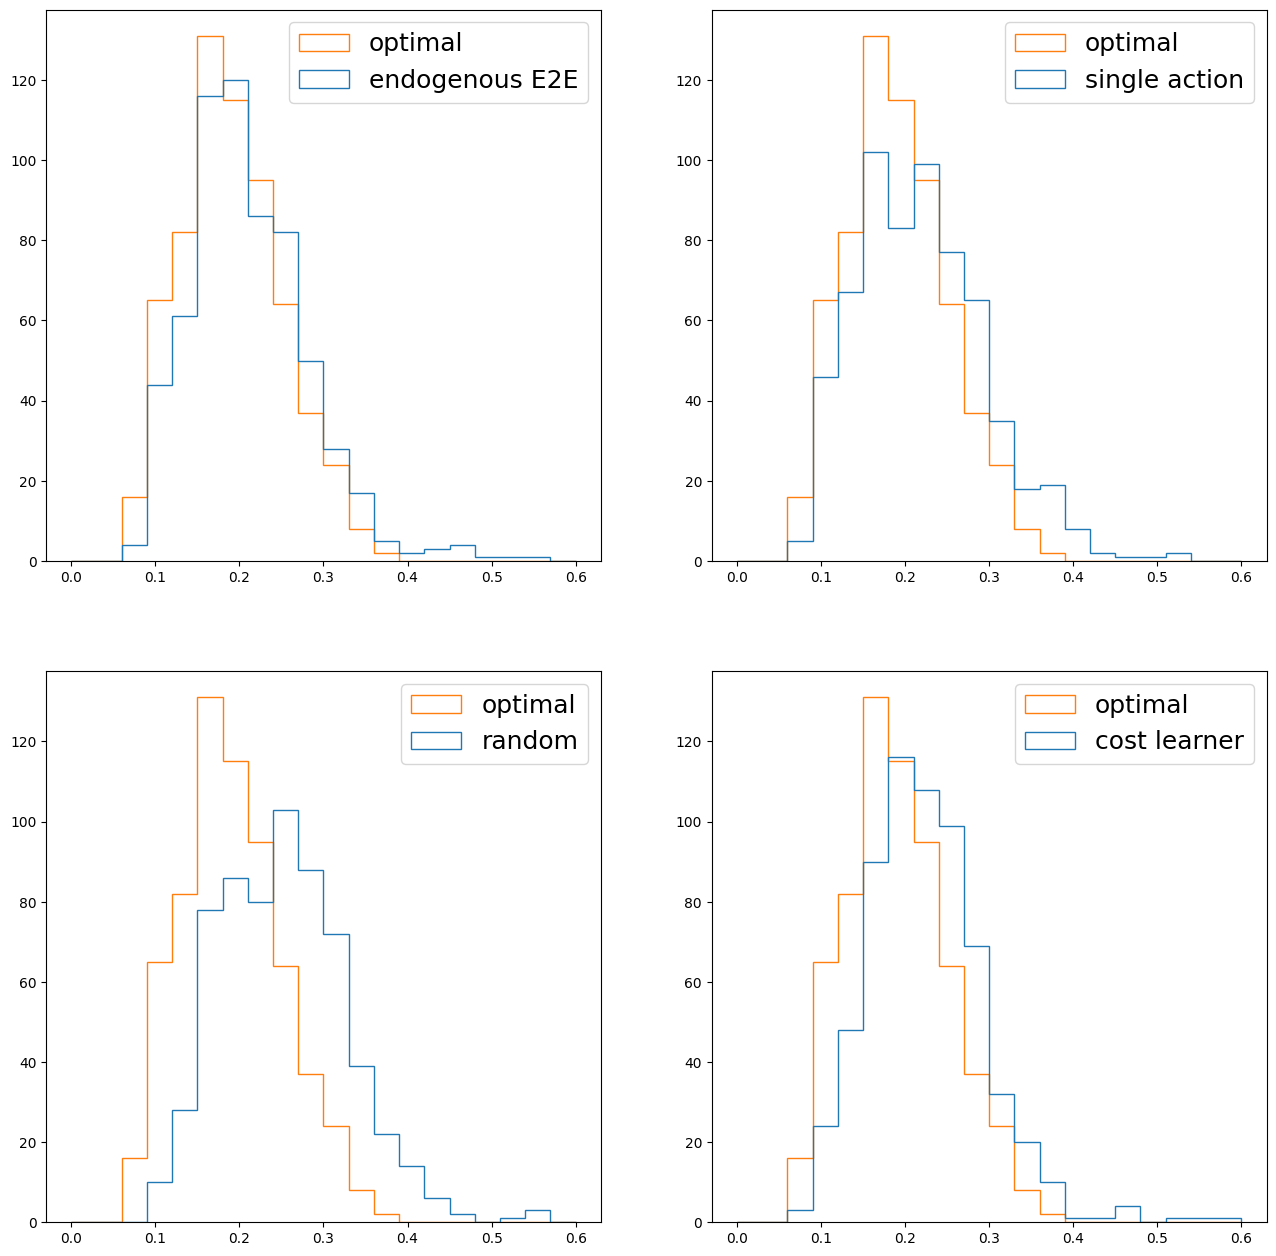

In [123]:
import matplotlib.pyplot as plt

bins = 20

cm = 1/2.54  # centimeters in inches
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(40*cm, 40*cm))
ax1.hist([ours, optimal], label=['endogenous E2E', 'optimal'], bins=bins, histtype='step', range=[0, 0.6])
ax1.legend(fontsize="18")
ax2.hist([all_costs[:,single_action], optimal], label=['single action', 'optimal'], bins=bins, histtype='step', range=[0,0.6])
ax2.legend(fontsize="18")
ax3.hist([random, optimal], label=['random', 'optimal'], bins=bins, histtype='step', range=[0,0.6])
ax3.legend(fontsize="18")
ax4.hist([reward_losses, optimal], label=['cost learner', 'optimal'], bins=bins, histtype='step', range=[0,0.6])
ax4.legend(fontsize="18")
plt.savefig('cost_distribution.png')


In [51]:
all_costs = np.array(all_costs)

In [255]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(24)], y=, mode='lines', name='data', marker=dict(color='green')))
fig.update_layout(xaxis_title='alpha', yaxis_title='Loss', title='Loss at w = 0.25, g(w,z)=1', width = 600, height = 600)
